In [1]:
import os, importlib, sys, time, h5py, glob

In [2]:
import numpy as np
from scipy import io, linalg, stats, ndimage, signal
from scipy.sparse import diags

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':12})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':12})
# rc('text', usetex=False)

In [4]:
import ladyns as ldn
import ladyns.inference as inf

In [6]:
save_dir = "../temp/Appendix_B2"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 0. Simulation parameters

In [7]:
dims = [25, 25]

In [8]:
num_rtime = 500
num_time = num_rtime // 10

## auto precision

In [9]:
alpha = 1.4
f = np.linspace(0, np.pi, num_rtime//2+1)[1:-1]
psd = 1/(f**alpha)

In [10]:
coords_S = [np.array(np.where(np.full((5,5), True))).T for _ in np.arange(2)]
sigmas_S = [0.8, 0.8]
covs_S = [np.exp(-np.sum((cd[:,None,:] - cd[None,:,:])**2,-1)
                 / (2 * sigma**2))
          for cd, sigma in zip(coords_S, sigmas_S)]

## cross precision

In [11]:
num_blobs = 3

In [12]:
f_beta = 18
cwt_omega = 3
cwt_scale = cwt_omega * 1000 / (2 * f_beta * np.pi)
filter_map = signal.morlet2(num_rtime, cwt_scale, cwt_omega)

In [13]:
ts_sig = [80, 200, 400]
ss_sig = [1250, 1750, 7500]
pbts = [np.exp(-np.square(np.arange(num_rtime) - t)/s)
       for t, s in zip(ts_sig, ss_sig)]

## nonstationarity

In [14]:
nsts = np.array([0, 0.3, 0.6, 0.9, 1.2, 1.5])

In [15]:
def lags_betas(nst):
    # generate latent direction and lead-lag
    lags = np.array([[0, nst*30, nst*30],
                     [nst*30, 0, 0]], dtype=np.int)
    
    ctrs = [[(2-nst, 2-nst), (2+nst, 2+nst), (2, 2)],
            [(2+nst, 2+nst), (2-nst, 2-nst), (2, 2)]]
    betas = [[np.exp(-np.sum((cd-ct)**2,-1)/(2*sig**2))
              for ct in ctr]
             for cd, ctr, sig in zip(coords_S, ctrs, sigmas_S)]
    
    return lags, betas

## true factor loadings

In [16]:
betas_true = np.zeros((len(nsts), 2, num_time, dims[0]))
for iter_nst, nst in enumerate(nsts):
    lags, betas = lags_betas(nst)
    fpbts = [
        signal.convolve(pbt, np.abs(signal.convolve(filter_map, filter_map, mode='same')))
        for pbt in pbts
    ]
    betas_true[iter_nst] = np.array([
        beta[0] * fpbts[0][num_rtime//2-lag[0]:-num_rtime//2-lag[0]+1:10,None]
        + beta[1] * fpbts[1][num_rtime//2-lag[1]:-num_rtime//2-lag[1]+1:10,None]
        + beta[2] * fpbts[2][num_rtime//2-lag[2]:-num_rtime//2-lag[2]+1:10,None]
        for beta, lag in zip(betas, lags)
    ])

/home/hbong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Palatino


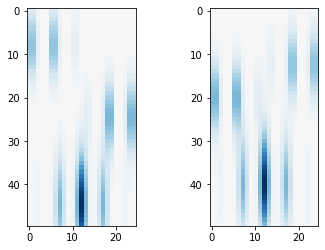

In [17]:
plt.subplot(1,2,1); ldn.imshow(betas_true[-1,0])
plt.subplot(1,2,2); ldn.imshow(betas_true[-1,1])

# 2. load simulation results

In [18]:
num_sim = len(glob.glob("%s/result_sim_*.npz"%(save_dir)))

In [19]:
num_sim

1000

In [20]:
Omegas_est = np.zeros([num_sim, 2*num_time, 2*num_time])
weights_init = np.zeros([num_sim, 2*num_time, dims[0]])
weights_est = np.zeros([num_sim, 2*num_time, dims[0]])

In [21]:
for iter_sim in range(num_sim): 
    
    result = np.load("%s/result_sim_%.3d.npz"%(save_dir,iter_sim))
    
    Omegas_est[iter_sim] = result["Omega_est"]
    weights_init[iter_sim] = np.array(result["weight_init"])
    weights_est[iter_sim] = np.array(result["weight_est"])

    sys.stdout.write("%d-th simulation loaded\n"%(iter_sim+1))
    sys.stdout.flush()  

1-th simulation loaded
2-th simulation loaded
3-th simulation loaded
4-th simulation loaded
5-th simulation loaded
6-th simulation loaded
7-th simulation loaded
8-th simulation loaded
9-th simulation loaded
10-th simulation loaded
11-th simulation loaded
12-th simulation loaded
13-th simulation loaded
14-th simulation loaded
15-th simulation loaded
16-th simulation loaded
17-th simulation loaded
18-th simulation loaded
19-th simulation loaded
20-th simulation loaded
21-th simulation loaded
22-th simulation loaded
23-th simulation loaded
24-th simulation loaded
25-th simulation loaded
26-th simulation loaded
27-th simulation loaded
28-th simulation loaded
29-th simulation loaded
30-th simulation loaded
31-th simulation loaded
32-th simulation loaded
33-th simulation loaded
34-th simulation loaded
35-th simulation loaded
36-th simulation loaded
37-th simulation loaded
38-th simulation loaded
39-th simulation loaded
40-th simulation loaded
41-th simulation loaded
42-th simulation loaded
4

334-th simulation loaded
335-th simulation loaded
336-th simulation loaded
337-th simulation loaded
338-th simulation loaded
339-th simulation loaded
340-th simulation loaded
341-th simulation loaded
342-th simulation loaded
343-th simulation loaded
344-th simulation loaded
345-th simulation loaded
346-th simulation loaded
347-th simulation loaded
348-th simulation loaded
349-th simulation loaded
350-th simulation loaded
351-th simulation loaded
352-th simulation loaded
353-th simulation loaded
354-th simulation loaded
355-th simulation loaded
356-th simulation loaded
357-th simulation loaded
358-th simulation loaded
359-th simulation loaded
360-th simulation loaded
361-th simulation loaded
362-th simulation loaded
363-th simulation loaded
364-th simulation loaded
365-th simulation loaded
366-th simulation loaded
367-th simulation loaded
368-th simulation loaded
369-th simulation loaded
370-th simulation loaded
371-th simulation loaded
372-th simulation loaded
373-th simulation loaded


662-th simulation loaded
663-th simulation loaded
664-th simulation loaded
665-th simulation loaded
666-th simulation loaded
667-th simulation loaded
668-th simulation loaded
669-th simulation loaded
670-th simulation loaded
671-th simulation loaded
672-th simulation loaded
673-th simulation loaded
674-th simulation loaded
675-th simulation loaded
676-th simulation loaded
677-th simulation loaded
678-th simulation loaded
679-th simulation loaded
680-th simulation loaded
681-th simulation loaded
682-th simulation loaded
683-th simulation loaded
684-th simulation loaded
685-th simulation loaded
686-th simulation loaded
687-th simulation loaded
688-th simulation loaded
689-th simulation loaded
690-th simulation loaded
691-th simulation loaded
692-th simulation loaded
693-th simulation loaded
694-th simulation loaded
695-th simulation loaded
696-th simulation loaded
697-th simulation loaded
698-th simulation loaded
699-th simulation loaded
700-th simulation loaded
701-th simulation loaded


990-th simulation loaded
991-th simulation loaded
992-th simulation loaded
993-th simulation loaded
994-th simulation loaded
995-th simulation loaded
996-th simulation loaded
997-th simulation loaded
998-th simulation loaded
999-th simulation loaded
1000-th simulation loaded


## plots

Text(0, 0.5, 'series 1 at time $t$ ms')

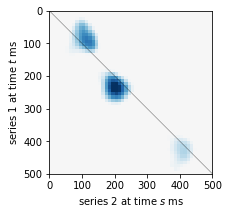

In [47]:
plt.figure(figsize=(3,3))
ldn.imshow(np.mean(np.abs(Omegas_est[:,:num_time,num_time:]), 0), vmax=0.0004,
           time=[0,500], identity=True)
plt.xlabel(r"series 2 at time $s$ ms")
plt.ylabel(r"series 1 at time $t$ ms")

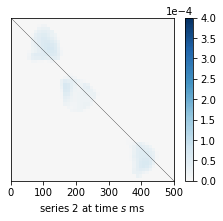

In [49]:
plt.figure(figsize=(4,3))
ldn.imshow(np.std(np.abs(Omegas_est[:,:num_time,num_time:]), 0), vmax=0.0004,
           time = [0,500], identity=True)
plt.xlabel(r"series 2 at time $s$ ms")
plt.yticks([],[])
cbar = plt.colorbar()
cbar.ax.set_ylim(0,4e-4); cbar.formatter.set_powerlimits((0, 0))

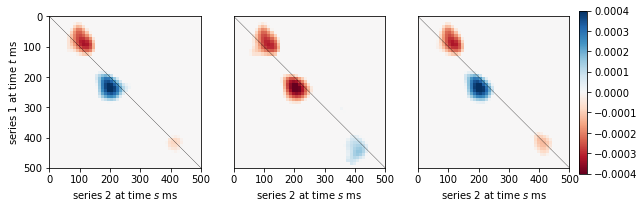

In [42]:
f, axes = plt.subplots(1,3, figsize=(10,3), gridspec_kw={'width_ratios':[3,3,3.75]})

randind = np.random.randint(1000, size=3)

for i, (ind,ax) in enumerate(zip(randind, axes)):
    plt.sca(ax)
    ldn.imshow(Omegas_est[ind,:num_time,num_time:], vmax=0.0004,
               time=[0,500], identity=True)
    plt.xlabel(r"series 2 at time $s$ ms")
    if i == 0:
        plt.ylabel(r"series 1 at time $t$ ms")
    else:
        ax.set_yticks([],[])
plt.colorbar()

# 3. projections

In [43]:
weight_axes = np.random.normal(size=[2,num_time,dims[0]])

In [49]:
np.savez('%s/weight_axes_sensitivity_anlaysis.npz'%save_dir,
         weight_axes = weight_axes)

In [30]:
locals().update(np.load('%s/weight_axes_sensitivity_anlaysis.npz'%save_dir))

In [31]:
wcds_init = np.tensordot(weights_init.reshape([num_sim,2,num_time,dims[0]]),
                         weight_axes, axes=((-1,-2),(-1,-2)))

In [32]:
wcds_est = np.tensordot(weights_est.reshape([num_sim,2,num_time,dims[0]]),
                         weight_axes, axes=((-1,-2),(-1,-2)))

## plots

In [33]:
import matplotlib.colors

cmap = plt.cm.rainbow
norm = [matplotlib.colors.Normalize(vmin=np.min(wcds_init[:,0,1]), vmax=np.max(wcds_init[:,0,1])),
        matplotlib.colors.Normalize(vmin=np.min(wcds_init[:,1,1]), vmax=np.max(wcds_init[:,1,1]))]

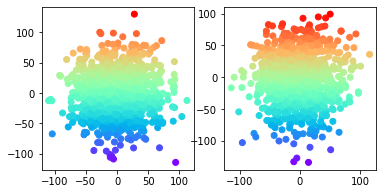

In [37]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.scatter(wcds_init[:,0,0],wcds_init[:,0,1],color=cmap(norm[0](wcds_init[:,0,1])))
plt.subplot(1,2,2); plt.scatter(wcds_init[:,1,0],wcds_init[:,1,1],color=cmap(norm[1](wcds_init[:,1,1])))

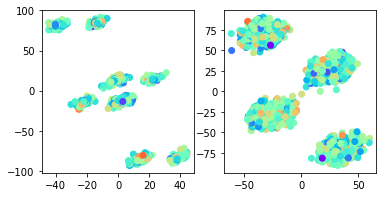

In [36]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.scatter(wcds_est[:,0,0],wcds_est[:,0,1],color=cmap(norm[0](wcds_init[:,0,1])))
plt.subplot(1,2,2); plt.scatter(wcds_est[:,1,0],wcds_est[:,1,1],color=cmap(norm[0](wcds_init[:,1,1])))